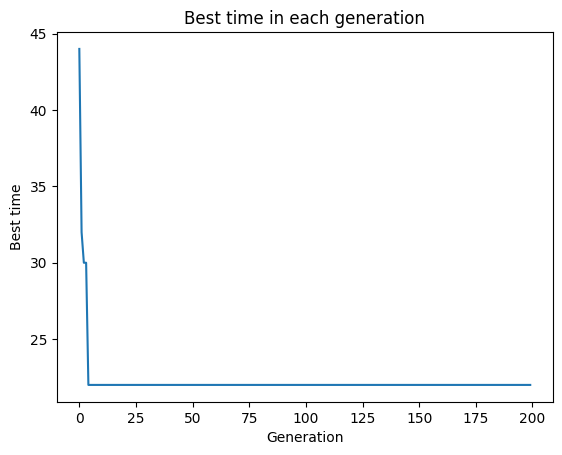

The total time was of: 22, it went from 'El Rosario' to 'Tacuba' in line '7', it went from 'Tacuba' to 'Tacubaya' in line '7', it went from 'Tacubaya' to 'Hidalgo' in line '2', it went from 'Hidalgo' to 'Bellas Artes' in line '2', it went from 'Bellas Artes' to 'Garibaldi' in line '8', it went from 'Garibaldi' to 'Morelos' in line 'B', it went from 'Morelos' to 'San Lázaro' in line 'B'


In [2]:
import random
from typing import List, Tuple
from rutas import *
from values import *
import matplotlib.pyplot as plt

Genome = Tuple[List[int], int, List[str], List[Tuple[str, str]]]

def generate_genome(rutas: List[Ruta], start_point: str, end_point: str) -> Genome:
    current_point, indexes, stages = start_point, [], []
    while current_point != end_point:
        i = random.choice([i for i, ruta in enumerate(rutas) if current_point == ruta.start])
        indexes.append(i)
        stages.append((current_point, rutas[i].end))
        current_point = rutas[i].end
    time = sum(rutas[i].time for i in indexes)
    lineas = [rutas[i].linea for i in indexes]
    return indexes, time, lineas, stages

def generate_population(rutas: List[Ruta], size_pop) -> List[Genome]:
    return [generate_genome(rutas, start_point, end_point) for _ in range(size_pop)]

def fitness(genome: Genome, rutas: List[Ruta]) -> float:
    return 1/genome[1] if genome[1] != 0 else 0

def elitism(population: List[Genome], rutas: List[Ruta], elite_size: int) -> List[Genome]:
    elite_size = max(2, elite_size)
    return sorted(population, key=lambda genome: fitness(genome, rutas), reverse=True)[:elite_size]

def mutate_genome(genome: Genome, rutas: List[Ruta], start_point: str, end_point: str) -> Genome:
    index_to_mutate = random.randint(1, len(genome[0]) - 1)
    new_start_point = rutas[genome[0][index_to_mutate - 1]].end
    new_route = generate_genome(rutas, new_start_point, end_point)
    new_genome = list(genome)
    new_genome[0] = new_genome[0][:index_to_mutate] + new_route[0]
    new_genome[1] = sum(rutas[i].time for i in new_genome[0])
    new_genome[2] = [rutas[i].linea for i in new_genome[0]]
    new_genome[3] = [(rutas[i].start, rutas[i].end) for i in new_genome[0]]
    return tuple(new_genome)

def crossover(parent1: Genome, parent2: Genome, rutas: List[Ruta]) -> Genome:
    common_points = set(parent1[3]).intersection(set(parent2[3]))
    if common_points:
        crossover_point = random.choice(list(common_points))
        crossover_index1 = parent1[3].index(crossover_point)
        crossover_index2 = parent2[3].index(crossover_point)
        child_route = parent1[0][:crossover_index1+1] + parent2[0][crossover_index2+1:]
        child_stages = parent1[3][:crossover_index1+1] + parent2[3][crossover_index2+1:]
    else:
        child_route = parent1[0]
        child_stages = parent1[3]
    child_time = sum(rutas[i].time for i in child_route)
    child_lineas = [rutas[i].linea for i in child_route]
    return child_route, child_time, child_lineas, child_stages

def create_new_population(population: List[Genome], rutas: List[Ruta], elite_size: int, mutation_rate: float) -> List[Genome]:
    elite = elitism(population, rutas, elite_size)
    # Create a copy of the elite genomes
    elite_copy = [genome for genome in elite]
    children = []
    for _ in range(size_pop - len(elite)):
        # Select parents for crossover from the elite genomes
        parent1, parent2 = random.sample(elite, 2)
        child = crossover(parent1, parent2, rutas)
        children.append(child)
    # Perform mutation on the elite genomes with a certain probability
    for i in range(len(elite)):
        if random.random() < mutation_rate:
            mutated = mutate_genome(elite[i], rutas, start_point, end_point)
            # Keep the genome with the higher fitness
            if fitness(mutated, rutas) > fitness(elite[i], rutas):
                elite[i] = mutated
    # Add the elite genomes and their copies to the new population
    return elite + elite_copy + children

def genetic_algorithm(rutas: List[Ruta], num_generations: int, elite_size: int, mutation_rate: float) -> Tuple[Genome, List[int]]:
    best_times = []
    population = generate_population(rutas, size_pop)
    for _ in range(num_generations):
        population = create_new_population(population, rutas, elite_size, mutation_rate)
        for i in range(len(population)):
            if random.random() < mutation_rate:
                mutated = mutate_genome(population[i], rutas, start_point, end_point)
                # Keep the genome with the higher fitness
                if fitness(mutated, rutas) > fitness(population[i], rutas):
                    population[i] = mutated
        best_genome = max(population, key=lambda genome: fitness(genome, rutas))
        best_times.append(1/best_genome[1] if best_genome[1] < 1 else best_genome[1])
        # Update elite_size based on the size of the elite from the last generation
        elite_size = len(elitism(population, rutas, elite_size))
    return best_genome, best_times

best_genome, best_times = genetic_algorithm(rutas, num_generations, elite_size, mutation_rate)

plt.plot(best_times)
plt.title('Best time in each generation')
plt.xlabel('Generation')
plt.ylabel('Best time')
plt.show()

# Print the desired string
print(f"The total time was of: {best_genome[1]}, " + ", ".join(f"it went from '{a}' to '{b}' in line '{linea}'" for (a, b), linea in zip(best_genome[3], best_genome[2])))